<a href="https://colab.research.google.com/github/lucarubini/LINKS_DeepLearning_Course/blob/main/time_series_tutorial/TF_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up TensorFlow

(questo tutorial e' basato sul tutorial uffciale di `Tensorflow` a [questa pagina](https://www.tensorflow.org/tutorials/quickstart/beginner))

Importiamo `TensorFlow` nel nostro notebook per iniziare il tutorial:


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


# Load a dataset
Carichiamo e prepariamo(normalizzando gli input) il dataset **MNIST** dataset. Convertiamo poi gli esempi in precisione floating point.

Questi passi di conversione e divisione train/test set sono tutti automatizzati, qualora si volesse lavorare su dati personali bisogna costruire la pipeline per fornire i dati al modello.

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
#Guardiamo quali sono le dimensioni degli elementi che abbiamo definito per il test/train
print("x_train.shape: {}".format(x_train.shape))
print("y_train.shape: {}".format(y_train.shape))

x_train.shape: (60000, 28, 28)
y_train.shape: (60000,)


Osserviamo ora come sono strutturati i dati e che 'aspetto' hanno le caratteristiche di `input/output`:

Label (target): 3


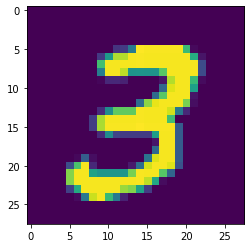

In [ ]:
idx_i = 7
#Show Image
plt.imshow(x_train[idx_i,:,:])
print("Label (target): {}".format(y_train[idx_i]))


# Build a (simple) machine learning model
Possiamo ora definireun modello usando il modulo di `keras` `tf.keras.Sequential`, che consiste in un modello dove i layers sono impilati uno dopo l'altro.
 
Considerando le caratteristiche dell'input e dell'output abbiamo:
*   Input: `28*28=784` pixels
*   Output: `10` classi

Il Layer di `tf.keras.layers.Flatten` trasforma un tensore, in questo caso una matrice quadrata in un singolo array concatenando tutti i valori. [Flatten Layer Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flattene)

Il Layer `tf.keras.layers.Dense` e' il layer per effetuare la moltiplicaizone matriciale e l'eventuale attivazione non-lineare. [Dense Layer Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

Osserviamo che anche se stiamo facendo un task di `multi-classification` usiamo come output del nostro modello un output lineare (e non `softmax`), questo perche' la funzione e' implementata all'interno della loss che abbiamo deciso di usare, ed e' proprio una specifica della funzione quella di ricevere un output ti tipo `Linear`.

  ![One prediction 24 hours into the future.](https://andreaprovino.it/wp-content/uploads/2020/09/tensorflow-neural-network-schema-tensorflow-mnist-tutorial-italiano-esempio-guida-tensorflow-italia-tensorflow-classification-hello-world-single-digit.png)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

Ispezioniamo ora il modello, per vedere da quali parametri(pesi) è costruito e che dimensione ha

In [ ]:
model.summary()

model.get_weights()

for i,W in enumerate(model.get_weights()):
    print("W_{}.shape: {}".format(i,W.shape))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
W_0.shape: (784, 128)
W_1.shape: (128,)
W_2.shape: (128, 10)
W_3.shape: (10,)


Per ciascun esempio il modello restituisce un vettore di logits della stessa lungehzza del numero delle classi (in questo caso `10`, un valore per ciascuna classe)

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.1958458 ,  0.41121256,  0.42560673, -0.5870664 ,  0.00310168,
        -0.84311926, -0.00756774, -0.03565638, -0.47903728,  0.01381977]],
      dtype=float32)

La funzione `tf.nn.softmax` converte l'output logits in distribuzione di probabilita'. Osserviamo quali sono le similitudini e differenze tra l'output logits e quello della softmax.

In [ ]:
predictions_softmax = tf.nn.softmax(predictions).numpy()
predictions_softmax

array([[0.12366626, 0.15338533, 0.15560915, 0.0565245 , 0.10198669,
        0.04375568, 0.10090434, 0.0981095 , 0.06297283, 0.10308567]],
      dtype=float32)

In [ ]:
print("Prediction.sum(): {}".format(predictions.sum()))
print("Prediction_softmax.sum(): {}".format(predictions_softmax.sum()))
print("Prediction sorted index: {}".format(predictions.argsort()[0]))
print("Prediction_softmax sorted index: {}".format(predictions_softmax.argsort()[0]))

Prediction.sum(): -0.9028605222702026
Prediction_softmax.sum(): 0.9999999403953552
Prediction sorted index: [5 3 8 7 6 4 9 0 1 2]
Prediction_softmax sorted index: [5 3 8 7 6 4 9 0 1 2]


Definiamo una funzione di `loss` per il training usando la funzione `losses.SparseCategoricalCrossentropy`, che prende in considerazione un vettore di logits (indicato tramite l'indice booleano `from_logits` e restituisce uno scalare per ciascun esempio.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Questa `loss` e' uguale alla `negative log probability` della classe corretta:  il valore della funzione `loss` vale zero se il modello resituisce la distribuzione corretta (che non significa che restituisca la classe corretta).

Un modello non addestrato (inizializzato in maniera casuale) restituisce una probabilita' prossiam a quella di aver scelto una classe casualmente (1/10 per ciascuna classe), cosi' la `loss` iniziale dovrebbe essere prossima al valore di `-tf.math.log(1/10) ~= 2.3.`

In [ ]:
loss_fn(y_train[:1], predictions).numpy()

3.1291337

Definiamo ora una funzione `probability_model` che possa resituire la distribuzione di probabilita' per il dato input.

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

Prima di incominciare l'addestramento, configurare e compilare il mdeollo usando le librerie del modulo `Keras`. Settiamo l'ottimizzatore come *Adam*, passiamo anche la `loss` e la metrica che vogliamo usare per valutare il modello (addestriamo seguendo la cross-entropy, ma poi valutiamo usando l'accuratezza).

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# Train and evaluate your model
Usiamo il metodo `Model.fit` per addestrare i parametri del modello in modo tale da minimizzare la funzione di `loss` per gli esempi presentati durante il training.

Osserviamo prima le performances del modello inizializzato casualmente.

Test sample n. 42--> p_out: 0.1679430902004242 class_out: 2 class_target: 7


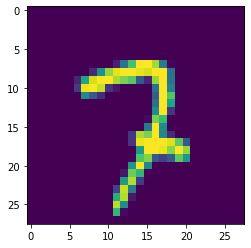

In [ ]:
#Performance on Test set BEFORE Training
example_test_idx = 42

plt.imshow(x_test[example_test_idx-1,:,:])
prob_out = probability_model(x_test[example_test_idx-1:example_test_idx,:,:])
print("Test sample n. {}--> p_out: {} class_out: {} class_target: {}".format(example_test_idx,prob_out.numpy().max(),prob_out.numpy().argmax(),y_test[example_test_idx-1]))

Osseriviamo come il metodo `fit` disponga di un'interfaccia grafica che monitora l'andamento dell'addestramento del modello.

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2594 - accuracy: 0.9262
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1154 - accuracy: 0.9664
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0791 - accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0586 - accuracy: 0.9822
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0460 - accuracy: 0.9862


Il metodo `Model.evaluate` implementa la valutazione del modello per misurare le performances, di solito per `"Validation-set"` or `"Test-set"`.

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0824 - accuracy: 0.9753 - 525ms/epoch - 2ms/step


[0.08239200711250305, 0.9753000140190125]

Il modello riporta un'accuratezza `>95%` sul test set, e' possibile aumentare ulteriormente l'accuratezza:
 ~98% accuracy on this dataset. To learn more, read the TensorFlow tutorials.

*   Inserendo un layer di Dropout
*   Definendo un modello piu' profondo/complesso
*   Definendo un nuovo modello (differente architettura)
*   Cambiando degli hparams
*   ...

Osserviamo ora qual e' l'output del modello per un batch di esempi, osserivamo che restituisce una matrice di array di dimensione `Number_of_examples x number_ofclasses` 

In [ ]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.96670692e-07, 5.41409406e-07, 4.79536866e-05, 2.24961364e-03,
        1.86286364e-09, 2.05629044e-06, 1.01910006e-12, 9.97597158e-01,
        7.15079732e-05, 3.07983137e-05],
       [4.14711110e-08, 2.48895609e-04, 9.99739945e-01, 9.79844663e-06,
        1.27727738e-16, 1.02361234e-07, 6.49256338e-09, 3.87007964e-14,
        1.15795137e-06, 2.62283434e-15],
       [5.52473637e-07, 9.96210694e-01, 3.88982269e-04, 3.10656214e-05,
        3.72519338e-04, 3.37898564e-05, 7.72957083e-06, 4.49178711e-04,
        2.50133546e-03, 4.11393103e-06],
       [9.99551237e-01, 3.58478403e-08, 4.93444031e-06, 7.28197904e-07,
        4.31413945e-08, 1.08524709e-07, 6.60813555e-07, 4.41848621e-04,
        8.04866243e-11, 5.34052049e-07],
       [6.34878802e-07, 2.91672642e-08, 2.62313300e-08, 1.55953772e-09,
        9.99438345e-01, 1.26350930e-08, 2.29302509e-06, 1.11653353e-05,
        7.49877813e-07, 5.46881056e-04]], dtype=float32)>

Osserviamo ora le performances del modello addestrato sugli stessi dati visti in precedensza, vediamo che le performances sono migliorate:

Test sample n. 42--> p_out: 0.9995068311691284 class_out: 7 class_target: 7


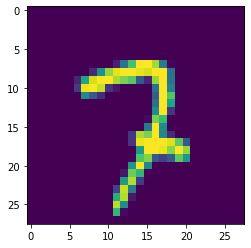

In [ ]:
#Performance on Test set AFTER Training

plt.imshow(x_test[example_test_idx-1,:,:])

prob_out = probability_model(x_test[example_test_idx-1:example_test_idx,:,:])
print("Test sample n. {}--> p_out: {} class_out: {} class_target: {}".format(example_test_idx,prob_out.numpy().max(),prob_out.numpy().argmax(),y_test[example_test_idx-1]))

# Conclusion
Congratulazioni abbiamo terminato il tutorial di `Tensorflow`. Per ulteriori dettagli e informazioni visita il sito ufficiale di [Tensorflow](https://www.tensorflow.org/).